# Summary

Model building for W207 Section 3 Model building. 

Here we develop a model using techniques such as Bidirectional Encoder Representations (BERT). This is from Transformers is a transformer-based machine learning technique for natural language processing pre-training developed by Google.





# Setup

In [1]:
!pip install transformers tensorflow keras numpy pandas nltk &> /dev/null
!echo "Packages installed"

Packages installed


## Packages

In [2]:
# Base
from google.colab import drive
import pandas as pd
import numpy as np
import os
import string
from datetime import date

import pickle
# Garbage Collector - use it like gc.collect()
import gc


# graphing
import matplotlib.pyplot as plt
import seaborn as sns

# tensor
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Lambda
from tensorflow.keras.layers import add, maximum, subtract, minimum

from transformers import AutoTokenizer
from transformers import TFBertModel

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')


%matplotlib inline

print(tf. __version__)

2.9.2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Functions

In [3]:
def save_np_ar(ob, name):
  f = os.path.join(project_path, "preprocessed_datasets", ''.join([name,".npy"]))
  np.save(f, ob)


def CleanFeatures(sentences):
  """
  Clean text data by removing punctuation and stop words. 

  Parameters:
    sentences (str): Description of arg1

  Returns:
    sentences (str): Cleaned text

  """
  sentences = sentences.apply(lambda sequence:
                                            [ltrs for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  sentences = sentences.apply(lambda sequence:
                                            [word for word in sequence.split() if word not in stop_words])
  sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  return sentences

def data_reshape(ar): 
  """
  Reshape input and attention mask arrays for model

  Extended description of function.

  Parameters:
    ar (array): Array to be reshaped into (N x 1)

  Returns:
    int: Description of return value

  """
  ar = np.reshape(ar, (ar.shape[0], ar.shape[2]))
  return ar

def input_mask(text, seq_len = 512): 
  """
    create the input and attention masks to be used in the Bert ResNet model

    ()

    Parameters: 
      text (array): Array containing strings to be tokenized and translated into input_ids
      seq_len (int): 

    Returns: 
      input_ids (array): 
      attention_mask (array):
  """

  input_ids = []
  attention_mask = []

  for index, value in enumerate(text):
    tokens = tokenizer.encode_plus(value, max_length = seq_len,padding = "max_length",
                                  truncation = True, return_token_type_ids = True,
                                  return_attention_mask = True,
                                  return_tensors = 'np')
    input_ids.append(tokens['input_ids'])
    attention_mask.append(tokens['attention_mask'])

  input_ids = np.asarray(input_ids)
  attention_mask = np.asarray(attention_mask)

  print("Input_ids shape: ", input_ids.shape)
  print("Attention_mask shape: ", attention_mask.shape)

  return input_ids, attention_mask

def as_array(ob): 
  ob = np.asarray(ob)
  return ob

### Graphing functions

In [4]:
def confusion_matrix_plot(conf_matrix):
  """
  Confusion matrix matplotlib plot
  # param conf_matrix: nested list of TP, TN, FP, FN
  # return: None
  """
  fig, ax = plt.subplots(figsize=(2.5, 2.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

  plt.xlabel('Predicted label')
  plt.ylabel('True label')

  plt.tight_layout()
  plt.show()

def cm_heatmap(cm, metric):
  """
  Create seaborn heatmap of a confustion matrix

  Used to visualize confustion matrix of models to understand where predictions are landing. 

  Parameters:
  cm (ndarray): confustion matrix in the shape (N x N). 

  Returns:
  ax (seaborn plot): heat map of confustion matrix

  """   
  plt.figure(figsize=(9,9))

  ax = sns.heatmap(
      cm, 
      linewidth = 1, 
      annot = True, 
      square = True,
      fmt = "d",
      cmap=sns.cubehelix_palette(as_cmap=True)
  )

  ax.set(
      xlabel = "True", 
      ylabel = "Predictions", 
      xticklabels = scores, 
      yticklabels = scores
  )

  ax.xaxis.tick_top()

  plt.title("".join(["Confustion Matrix for ", metric, "\n"]), fontdict = titleFontDict)

  plt.show()

  return ax

### Model Functions: 

In [5]:
def resnet(inputs, units):
  """ 
    Residual Networks (ResNet) set up.

    Simple function to be used to create object to refer to ResNet component with long-short-term-memory layer followed by a batch normalization. 
    Batch normalization will normalize the data to have a mean around 0, with a standard deviation near 1. 

    Parameters: 
      inputs (): 
      units (): 
    
    Returns: 
      x (tf.keras.layer): LSTM with batch normalization keras layer

  """
  x = tf.keras.layers.LSTM(units,return_sequences = True,)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  return x

def model_accuracy(labels, predictions): 
  """
    Evaluate model accuracy. 

    Parameters: 
      lables (array): true labels from data set
      predictions (array): output from model.predict()

    Returns: 
      accuracy (float): accuracy for given model predictions
  """
  accuracy = np.sum(labels == predictions) / labels.shape[0] * 100
  
  return accuracy

def create_cm(labels, predictions): 
  """
    Create confustion matrix to be used in "confusion_matrix_plot()"

    Parameters: 
      lables (array): true labels from data set
      predictions (array): output from model.predict()

    returns: 
      cm (matrix): confusion matrix
  """
  predictions = np.round(predictions/0.5) * 0.5

  cm = confusion_matrix(labels.astype("str"), predictions.astype("str"))

  return cm

## Paths

In [6]:
# Mount google drive
drive.mount('/content/drive/')

# alternative way: 
main_path = "/content/drive/MyDrive/"

project_path = "W207_final_project/"
data_path = "data/"
save_path = "".join([date.today().strftime('%Y%m%d'), "_models/"])

project_path = "".join([main_path, project_path])
data_path = "".join([project_path, data_path])
save_path = "".join([project_path, save_path])

# Sanity Check
print("project path: ", project_path)
print("data path: ", data_path)
print("save path: ", save_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
project path:  /content/drive/MyDrive/W207_final_project/
data path:  /content/drive/MyDrive/W207_final_project/data/
save path:  /content/drive/MyDrive/W207_final_project/20221207_models/


# Preprocessing

In [7]:
# Load data
train = pd.read_csv(os.path.join(data_path, "train.csv"))
print(train.shape)

test = pd.read_csv(os.path.join(data_path, "test.csv"))
print(test.shape)

(3911, 8)
(3, 2)


In [8]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

### Split data into sets

In [9]:
# Train, valid, test split
# still need validation data
X_train, X_test, y_train, y_test = train_test_split(train['full_text'], train[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']], 
                                                      test_size = 0.3, 
                                                      random_state = 0)

# inspect split: 
print("Shapes:")
print("  X_train: ", X_train.shape)
print("  X_test: ", X_test.shape)
print("  y_train: ", y_train.shape)
print("  y_test: ", y_test.shape)

Shapes:
  X_train:  (2737,)
  X_test:  (1174,)
  y_train:  (2737, 6)
  y_test:  (1174, 6)


In [10]:
# clean up text for input
print("-- Before --")
print(X_train[0:5])

X_train = CleanFeatures(X_train)

print("")
print("-- After --")
print(X_train[0:5])

-- Before --
3122    I agree honesty is the best policy but sometim...
3757    "All students must participate in at least one...
113     Yes you should learn wisdom and experience to ...
934     thi don't really select a work in wat iam inte...
454     We should allow the students to bring there ce...
Name: full_text, dtype: object

-- After --
3122    I agree honesty best policy sometimes honesty ...
3757    All students must participate least one extrac...
113     Yes learn wisdom experience understand To lear...
934     thi dont really select work wat iam interest w...
454     We allow students bring cell phones school sch...
Name: full_text, dtype: object


In [11]:
# clean up text for input
print("-- Before --")
print(X_test[0:5])

X_test = CleanFeatures(X_test)

print("")
print("-- After --")
print(X_test[0:5])

-- Before --
2759    Has there been anyone in your life that shared...
192     Dear principal,\n\nI am very honored to write ...
2066    Do you think attitude is a big part of life? I...
2491    First impressions are always the most importan...
598     There is a debate today day about whether the ...
Name: full_text, dtype: object

-- After --
2759    Has anyone life shared wisdom experience If as...
192     Dear principal I honored write letter pray tak...
2066    Do think attitude big part life In society tod...
2491    First impressions always important thing meet ...
598     There debate today day whether students study ...
Name: full_text, dtype: object


In [12]:
list_words = [len(text.split()) for text in X_train]

print(np.max(list_words))

# this means that some of the essays will be truncated. I wonder if we could use a batch processing like in cornelia's notebook would work better for these longer essays. 
seq_len = 512

610


In [ ]:
# Create input index and attention mask for model
train_input_ids, train_attention_mask = input_mask(X_train, 512)

train_input_ids = data_reshape(train_input_ids)
train_attention_mask = data_reshape(train_attention_mask)

save_np_ar(train_input_ids, "train_input_ids")
save_np_ar(train_attention_mask, "train_attention_mask")

# Sanity check
train_input_ids[1]

In [ ]:
# Repeat with test set. 
test_input_ids, test_attention_mask = input_mask(X_test, 512)

test_input_ids = data_reshape(test_input_ids)
test_attention_mask = data_reshape(test_attention_mask)

save_np_ar(test_input_ids, "test_input_ids")
save_np_ar(test_attention_mask, "test_attention_mask")


In [ ]:
save_np_ar(test_input_ids, "test_input_ids")

## Set up outcome variable objects

In [15]:
# Create labels
outcome_vars = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

y_train_dict = {ov:as_array(y_train[ov]) for ov in outcome_vars}
y_test_dict = {ov:as_array(y_test[ov]) for ov in outcome_vars}

y_train_dict

{'cohesion': array([2.5, 3.5, 2. , ..., 3. , 3.5, 3. ]),
 'syntax': array([2.5, 3. , 2. , ..., 4. , 3. , 3.5]),
 'vocabulary': array([3. , 3.5, 2.5, ..., 3.5, 3.5, 3.5]),
 'phraseology': array([2.5, 3.5, 3. , ..., 3.5, 3. , 3. ]),
 'grammar': array([2.5, 3.5, 2.5, ..., 3.5, 3. , 3.5]),
 'conventions': array([2.5, 3. , 2. , ..., 3. , 3. , 3.5])}

# Model Setup


In [16]:
# Bert model used from TF. 
bert = TFBertModel.from_pretrained('bert-base-cased')
bert.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [17]:
# input layer and attention mask
input_ids_m = tf.keras.layers.Input(shape = (seq_len, ), dtype = "int32")
attention_mask_n = tf.keras.layers.Input(shape = (seq_len, ),  dtype = "int32") # changed from "int32"
# token_type_ids = tf.keras.layers.Input((seq_len,), dtype = tf.int32) # this is new

#
bert_m = bert.bert([input_ids_m, attention_mask_n])[0] # added in tokens

# 
units = 16
x = resnet(bert_m, units)

# build network
for stack in range(1):
  for block in range(3):
    y = resnet(x, units)
    if stack > 0 and block == 0:
      x = tf.keras.layers.LSTM(units, return_sequences = True, dropout=0.2, recurrent_dropout=0.2)(x)
    x = minimum([x, y])

  units *=2

# Additional layer types 
x1 = tf.keras.layers.GlobalAveragePooling1D()(x)
x2 = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.concatenate([x1, x2], name="our_param")

y = tf.keras.layers.Dense(1)(x)

m = tf.keras.models.Model(inputs = [input_ids_m, attention_mask_n], outputs = [y])  
m.layers[2].trainable = False

m.summary()

m.compile(loss= "mse", optimizer= tf.keras.optimizers.Adam(0.1), metrics = ['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

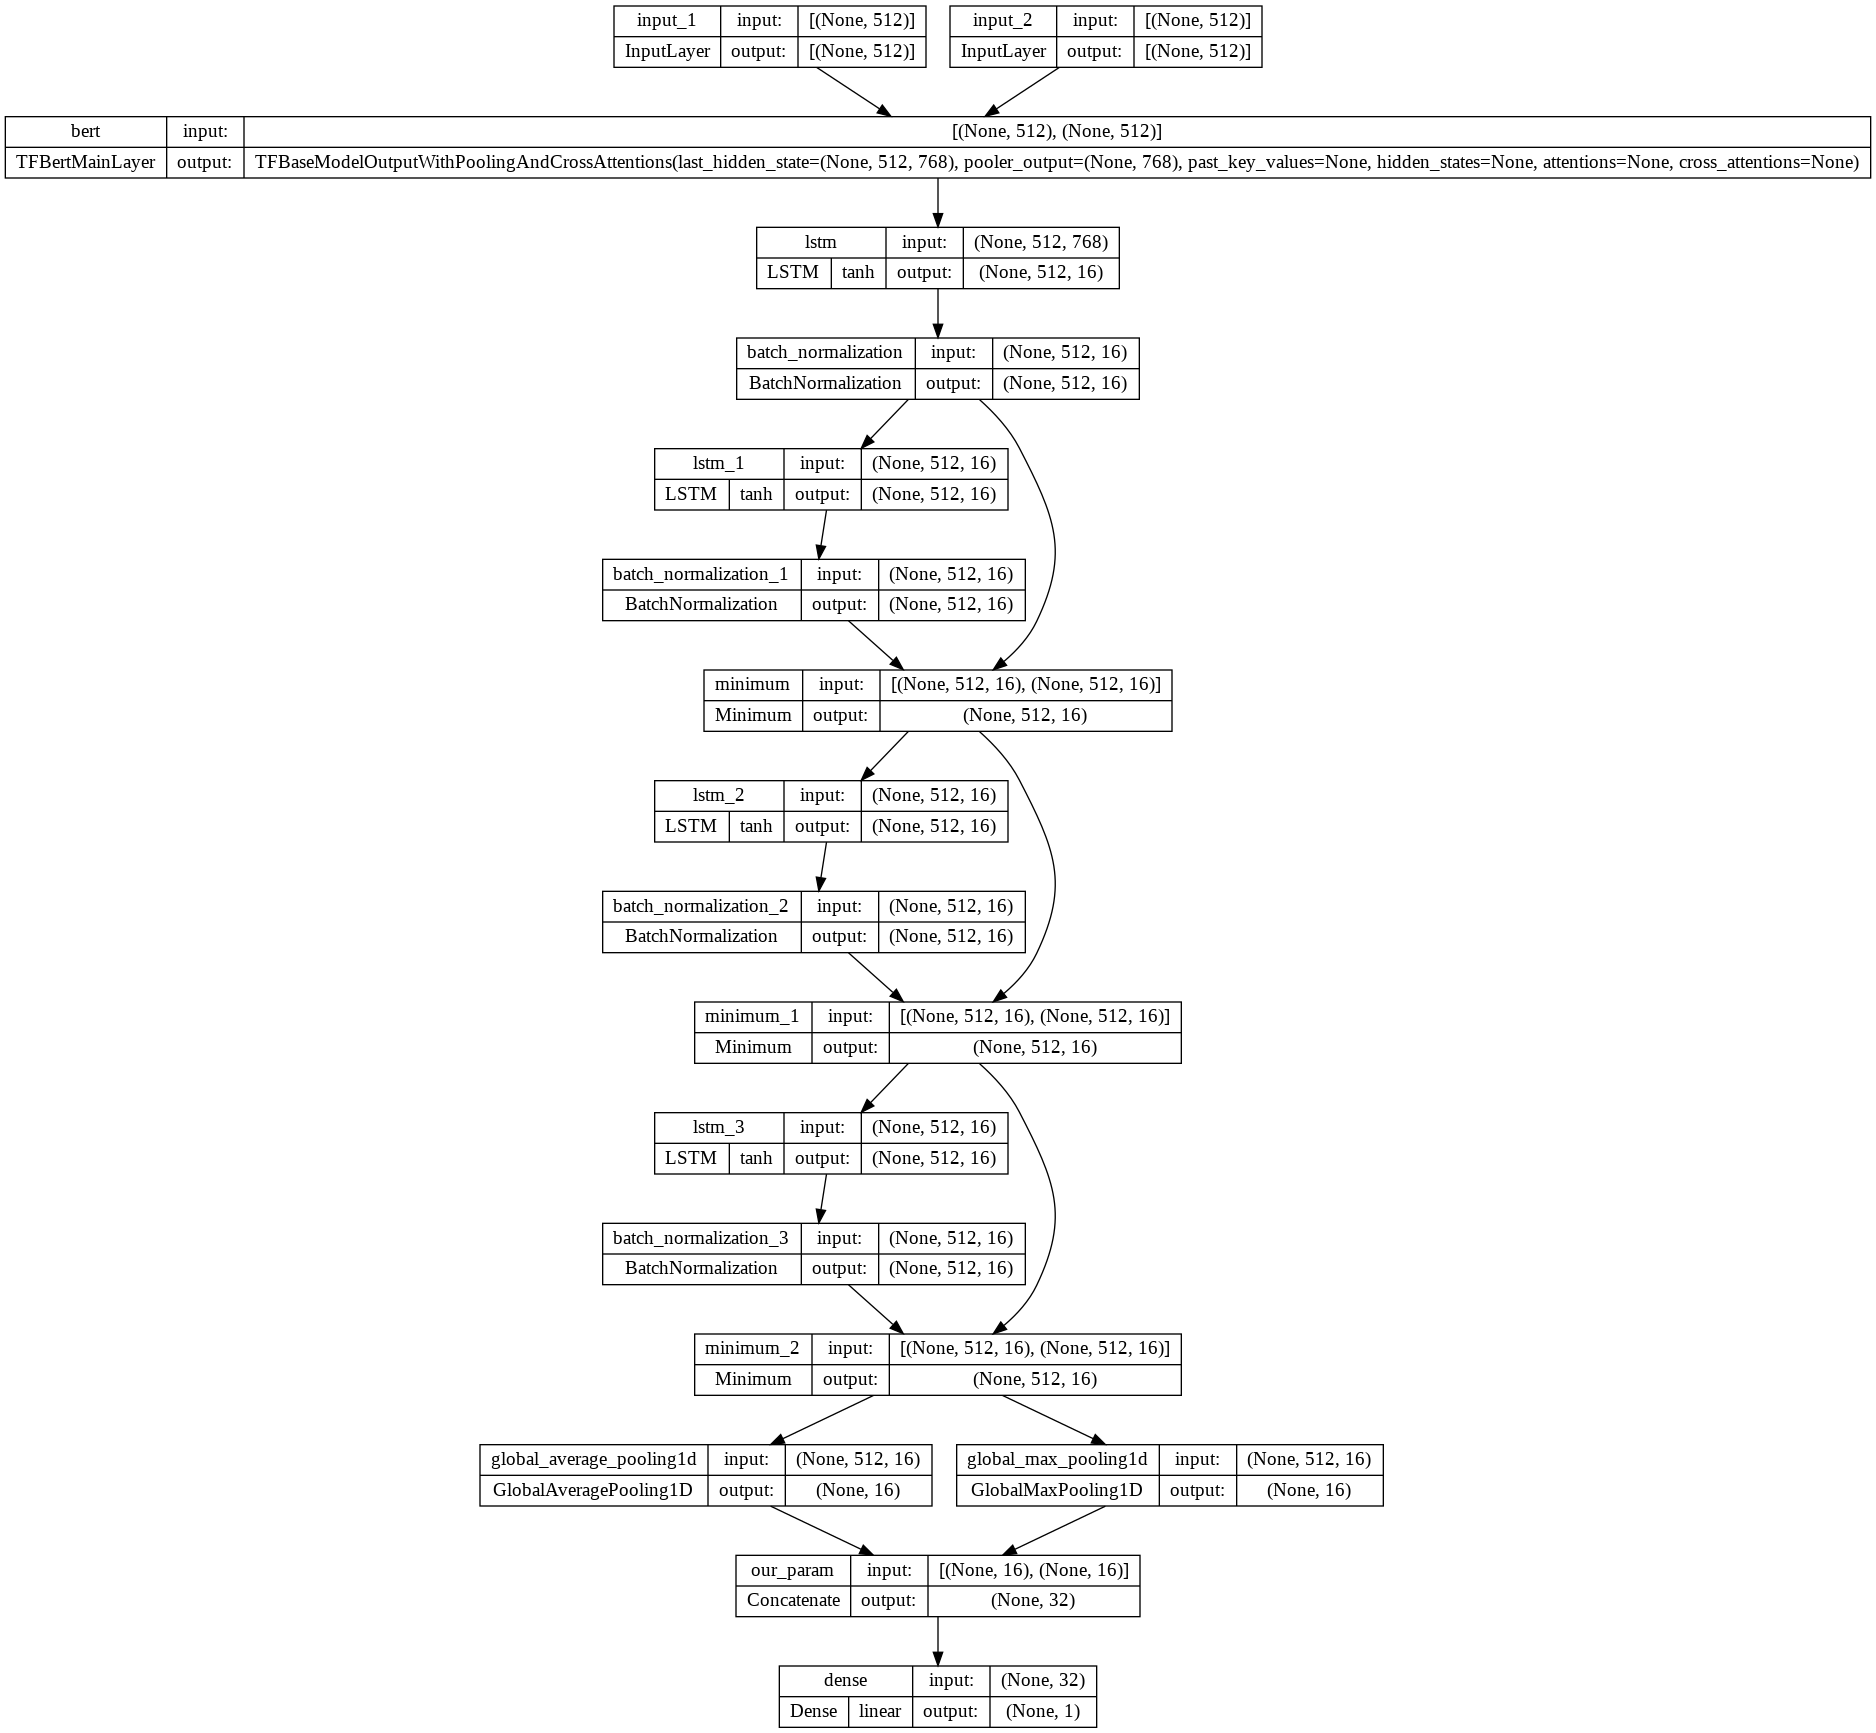

In [18]:
tf.keras.utils.plot_model(m, show_shapes=True, 
                          show_dtype=False, 
                          show_layer_names=True, 
                          expand_nested=True, 
                          show_layer_activations=True)

## Train Model

In [19]:
for k, v in y_train_dict.items(): 
  print(k)
  print(v)

cohesion
[2.5 3.5 2.  ... 3.  3.5 3. ]
syntax
[2.5 3.  2.  ... 4.  3.  3.5]
vocabulary
[3.  3.5 2.5 ... 3.5 3.5 3.5]
phraseology
[2.5 3.5 3.  ... 3.5 3.  3. ]
grammar
[2.5 3.5 2.5 ... 3.5 3.  3.5]
conventions
[2.5 3.  2.  ... 3.  3.  3.5]


Takes ~ 1.5 hours with GPU

In [20]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
models = {}

history = {}

for k, v in y_train_dict.items(): 
    history_training = m.fit([train_input_ids, train_attention_mask],
                         y = v,
                         batch_size= 128, 
                         epochs= 6,
                         callbacks = [
                             tf.keras.callbacks.ReduceLROnPlateau(
                                monitor='loss', 
                                factor=0.1, 
                                mode = 'min',
                                patience= 2),
                             tf.keras.callbacks.EarlyStopping(
                                patience = 2, 
                                monitor = 'loss', 
                                mode = 'min', 
                                restore_best_weights=True), 
                            tf.keras.callbacks.ModelCheckpoint(
                                filepath="".join([save_path,"model_checkpoints/", k, "/model_", k, ".{epoch:02d}-{loss:.4f}"]), 
                                save_freq='epoch', verbose=1, monitor='loss', 
                                save_weights_only=True, save_best_only=False)]
    )
    models[k] = m
    history[k] = history_training

Epoch 1/6
22/22 [==============================] - ETA: 0s - loss: 1.7146 - accuracy: 0.0015
Epoch 1: saving model to /content/drive/MyDrive/W207_final_project/20221207_models/model_checkpoints/cohesion/model_cohesion.01-1.7146
22/22 [==============================] - 158s 6s/step - loss: 1.7146 - accuracy: 0.0015 - lr: 0.1000
Epoch 2/6
22/22 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.0018
Epoch 2: saving model to /content/drive/MyDrive/W207_final_project/20221207_models/model_checkpoints/cohesion/model_cohesion.02-0.4394
22/22 [==============================] - 138s 6s/step - loss: 0.4394 - accuracy: 0.0018 - lr: 0.1000
Epoch 3/6
22/22 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.0018
Epoch 3: saving model to /content/drive/MyDrive/W207_final_project/20221207_models/model_checkpoints/cohesion/model_cohesion.03-0.3906
22/22 [==============================] - 138s 6s/step - loss: 0.3906 - accuracy: 0.0018 - lr: 0.1000
Epoch 4/6
22/

In [32]:
for k in history.keys():
  with open("".join([save_path, "/model_history_", k, ".csv"]), "w") as f:
    pd.DataFrame(history[k].history).to_csv(f)

## Save models

In [23]:
# Save model weights: 
for k, m in models.items():
  m.save_weights("".join([save_path,"weights/", k]))

In [24]:
# Save full models
for k, m in models.items():
  tf.keras.models.save_model(model = m,
                      filepath = "".join([save_path, k]))

# Model Evaluation

In [42]:
def plot_history(history):
  """ 
  For plotting the histories from models
  
  Prints matplot lib graphs of the accuracy and loss over epochs used during training

  Parameters: 
    history: object from model.fit(...)

  Returns: 
    None

  """
  
  hist = history.history
  x_arr = np.arange(len(hist['loss'])) + 1

  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 2, 1)
  ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Loss', size=15)

  ax = fig.add_subplot(1, 2, 2)
  ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Accuracy', size=15)
  ax.set_ylim(0,1)
  plt.show()

  return ax

cohesion


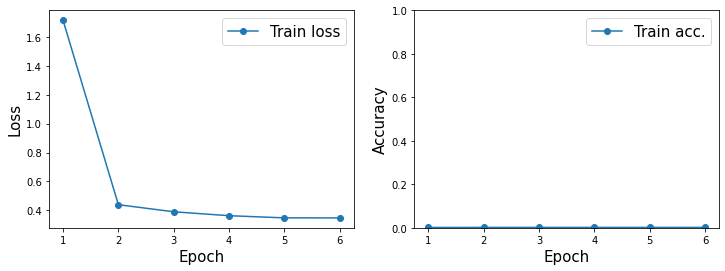

syntax


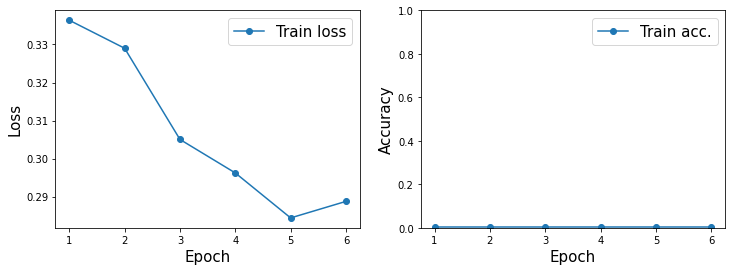

vocabulary


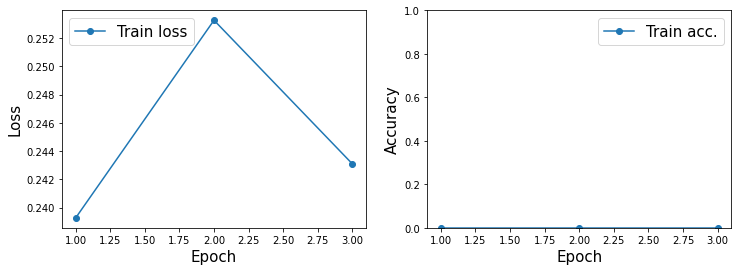

phraseology


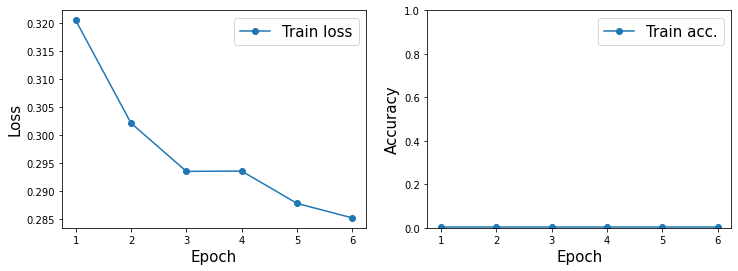

grammar


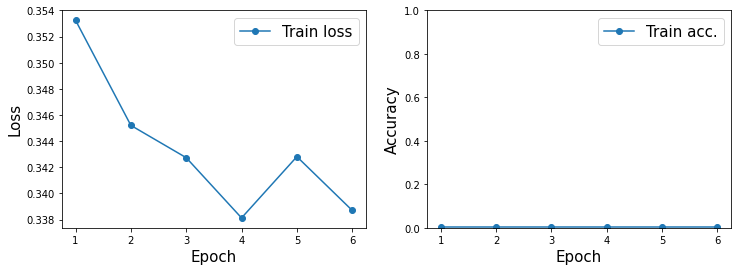

conventions


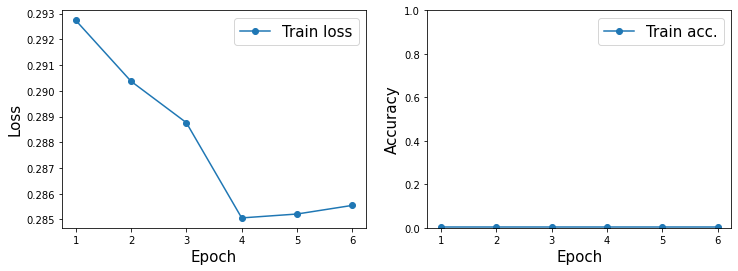

In [43]:
for k in history.keys():
  print(k)
  fig = plot_history(history[k])
  fig.figure.savefig(''.join([save_path, "model_", "k", "_results.png"]), dpi = 300)

In [66]:
epochs = [i for i in range(1,7)]

In [71]:
len(history[k].history['loss'])

3

In [67]:
epochs

[1, 2, 3, 4, 5, 6]

In [72]:
model_histories = pd.DataFrame()

for k in history.keys():
  temp = pd.DataFrame(history[k].history)
  temp['outcome_var'] = k
  temp['epoch'] = [i for i in range(1,len(history[k].history['loss'])+1)]
  model_histories = pd.concat([model_histories, temp], axis = 0)

model_histories

,loss,accuracy,lr,outcome_var,epoch
0,1.714566,0.001461,0.100,cohesion,1
1,0.439445,0.001827,0.100,cohesion,2
2,0.390595,0.001827,0.100,cohesion,3
3,0.363496,0.001827,0.100,cohesion,4
4,0.348494,0.001827,0.100,cohesion,5
5,0.348128,0.001827,0.100,cohesion,6
0,0.336372,0.002192,0.100,syntax,1
1,0.329011,0.002192,0.100,syntax,2
2,0.305039,0.002192,0.100,syntax,3
3,0.296233,0.002192,0.100,syntax,4


In [92]:
model_histories.dtypes

loss           float64
accuracy       float64
lr             float32
outcome_var     object
epoch            int64
dtype: object

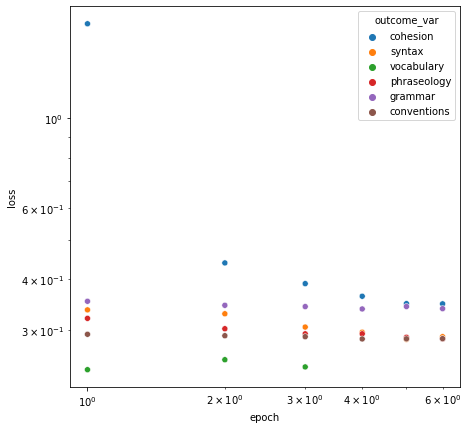

In [94]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(data=model_histories, x="epoch", y="loss", hue="outcome_var")

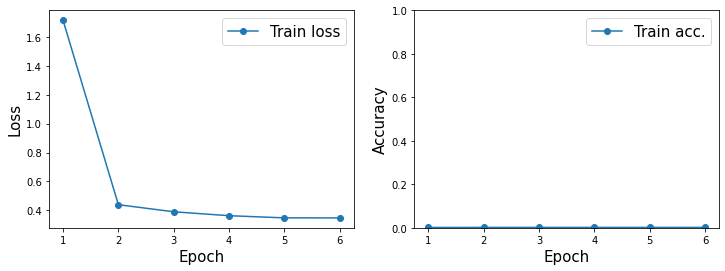

In [38]:
for k in history.keys():
  hist = history[k].history
  x_arr = np.arange(len(hist['loss'])) + 1

  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 2, 1)
  ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Loss', size=15)

  ax = fig.add_subplot(1, 2, 2)
  ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Accuracy', size=15)
  ax.set_ylim(0,1)
  plt.show()

In [25]:
# test evaluations
test_results = models['vocabulary'].evaluate([test_input_ids, test_attention_mask], y_test_dict['vocabulary'])

37/37 [==============================] - 54s 1s/step - loss: 0.2769 - accuracy: 8.5179e-04


In [26]:
# create and save predictions: 
models_predictions = {}

for k in models.keys(): 
  prediction_results = models[k].predict([test_input_ids, test_attention_mask])
  models_predictions[k] = prediction_results
  np.save("".join([save_path,"/",k,"_predict.npy"]), prediction_results)

37/37 [==============================] - 51s 1s/step


## Evaluate Predictions

In [27]:
models.keys()

dict_keys(['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'])

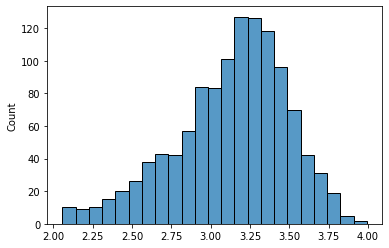

In [28]:
sns.histplot(np.squeeze(models_predictions['vocabulary']))

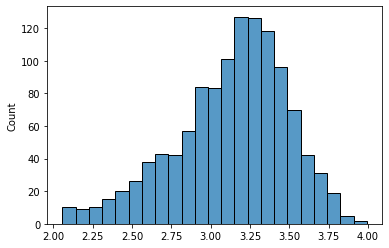

In [29]:
sns.histplot(np.squeeze(models_predictions['phraseology']))

### Metrics

### Confusion Matrix

In [30]:
scores = [i/2 for i in range(2, 11)]

titleFontDict = {"fontsize":20,
                 'verticalalignment': 'top',
                 'horizontalalignment':'right'}

In [31]:
model_accuracies = {}
model_cm = {}

for k in models_predictions.keys():
  predictions = models_predictions[k]
  labels = y_test_dict[k]
  model_accuracies[k] = model_accuracy(labels, predictions)
  cm = create_cm(labels, predictions)
  model_cm[k] = cm
  cm_hm = cm_heatmap(cm, k)
  cm_hm.savefig("".join([save_path, k,"_cm_heat_map.png")


SyntaxError: ignored

In [ ]:
with open("".join([save_path, "/model_accuracies.pkl"]), "w") as f:
  pickle.dump(model_accuracies, f)

In [ ]:
with open("".join([save_path, "/model_confusion_matrices.pkl"]), "w") as f:
  pickle.dump(model_cm, f)